In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from IPython.display import clear_output
import tensorflow as tf

In [ ]:
!gdown https://drive.google.com/uc?id=1fp0O4cfPwB_QEZ7IrlpqwXRWmk-K64nK
!unzip -qq SegmentationData

Downloading...
From: https://drive.google.com/uc?id=1fp0O4cfPwB_QEZ7IrlpqwXRWmk-K64nK
To: /home/maksim/Desktop/Diploma/SegmentationData.zip
 66%|█████████████████████████▎            | 37.7M/56.8M [00:10<00:04, 4.00MB/s]

## EDA

In [ ]:
# load labels
with open("Пакеты_трейн/train_labels.json", "r") as f:
  train_labels = json.load(f)
with open("Пакеты_тест/test_labels.json", "r") as f:
  test_labels = json.load(f)

In [ ]:
# Let's visualize train data
n = 0
circle_size = 5

while n != 5:
  img_name = np.random.choice(list(train_labels.keys()))
  metadata = train_labels[img_name]
  # rad img
  img = cv2.imread("Пакеты_трейн/" + metadata["filename"])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  gt = img.copy()
  # skip zero images
  if img.sum() == 0 or metadata["regions"] == {}:
    continue
  # plot labels
  for i in metadata["regions"].values():
    coords = (i["shape_attributes"]["cx"], i["shape_attributes"]["cy"])
    gt = cv2.circle(gt, coords, circle_size, 255, cv2.FILLED)

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(12,10))
  ax[0].imshow(img)
  ax[0].set_title(metadata["filename"])
  ax[1].imshow(gt)
  ax[1].set_title(f"Number of rods: {len(metadata['regions'].values())}")
  plt.show()

  n += 1

1) We can use cricles to create GT. 2) It's not obvious how to choose optimul circle_size, let's left if 5. 3) We need to left only images that contain some data and some labels.

In [22]:
# left only "normal" data
train_gt = {}

for img_name in tqdm(train_labels):
  metadata = train_labels[img_name]
  if metadata["regions"] == {}:
    continue
  img = cv2.imread("Пакеты_трейн/" + metadata["filename"])
  if img.sum() == 0:
    continue
  train_gt[img_name] = metadata

print(f"New train size: {len(train_gt)}, Previous train size: {len(train_labels)}")

  0%|          | 0/4573 [00:00<?, ?it/s]

New train size: 2632, Previous train size: 4573


In [23]:
# shuffle
keys = list(train_gt.keys())
np.random.shuffle(keys)

# Prepare data for train
train_data, train_labels = [], []
for img_name in keys[:-500]:
  metadata = train_gt[img_name]
  # get data
  img = cv2.imread("Пакеты_трейн/" + metadata["filename"])
  train_data.append(img.astype("float32") / 255)
  # get labels
  gt = np.zeros_like(img[..., :1])
  for i in metadata["regions"].values():
    coords = (i["shape_attributes"]["cx"], i["shape_attributes"]["cy"])
    gt = cv2.circle(gt, coords, circle_size, 1, cv2.FILLED)
  train_labels.append(gt.astype("float32"))

train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Prepare data for val
val_data, val_labels = [], []
for img_name in keys[-500:]:
  metadata = train_gt[img_name]
  # get data
  img = cv2.imread("Пакеты_трейн/" + metadata["filename"])
  val_data.append(img.astype("float32") / 255)
  # get labels
  gt = np.zeros_like(img[..., :1])
  for i in metadata["regions"].values():
    coords = (i["shape_attributes"]["cx"], i["shape_attributes"]["cy"])
    gt = cv2.circle(gt, coords, circle_size, 1, cv2.FILLED)
  val_labels.append(gt.astype("float32"))

val_data = np.array(val_data)
val_labels = np.array(val_labels)

print(f"Train data size: {train_data.shape}, Val data size: {val_data.shape}")
print(f"Train labels size: {train_labels.shape}, Val labels size: {val_labels.shape}")

Train data size: (2132, 256, 256, 3), Val data size: (500, 256, 256, 3)
Train labels size: (2132, 256, 256, 1), Val labels size: (500, 256, 256, 1)


In [24]:
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, data, labels, batch_size=1, shuffle=False):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(data))

        # self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append([self.data[j], self.labels[j]])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

In [25]:
train_dataloader = Dataloder(train_data, train_labels, batch_size=16, shuffle=True)
valid_dataloader = Dataloder(val_data, val_labels, batch_size=16, shuffle=True)

In [26]:
for x in train_dataloader:
    break

## Segmentation Model

In [27]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [28]:
# load pretrained model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]
  
sm.set_framework('tf.keras')
model = sm.Unet(backbone_name='resnet34', classes=1, activation="sigmoid")
model.compile(tf.keras.optimizers.Adam(0.001), loss=sm.losses.dice_loss, metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])

2022-03-02 17:36:32.448836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 17:36:32.494127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 17:36:32.494247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 17:36:32.498103: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [29]:
%%time
# fit model
history = model.fit(train_dataloader,
                    steps_per_epoch=len(train_dataloader),
                    epochs=1,
                    validation_data=valid_dataloader,
                    validation_steps=len(valid_dataloader),
                    callbacks=callbacks)

2022-03-02 17:36:39.782840: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-03-02 17:36:40.721329: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


133/133 [==============================] - 31s 176ms/step - loss: 0.4765 - iou_score: 0.4665 - f1-score: 0.6118 - val_loss: 0.9781 - val_iou_score: 1.9625e-10 - val_f1-score: 1.9625e-10 - lr: 0.0010
CPU times: user 26.5 s, sys: 662 ms, total: 27.1 s
Wall time: 31.5 s


Metrics looks not bad. Let's see on predicts and collect MAPE

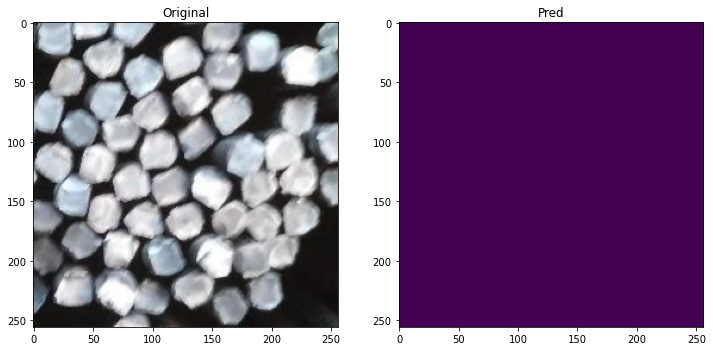

In [30]:
# vis predict
original_img = train_dataloader[0][0][5]
pred = (model.predict(train_dataloader[0][0][5:6]) > 0.5)[0, ..., 0]

# plot
fig, ax = plt.subplots(1, 2, figsize=(12,10))
ax[0].imshow(original_img)
ax[0].set_title("Original")
ax[1].imshow(pred)
ax[1].set_title("Pred")
plt.show()

In [34]:
train_dataloader[0][0][5:6]

array([[[[0.5921569 , 0.6039216 , 0.63529414],
         [0.15294118, 0.16470589, 0.19607843],
         [0.15686275, 0.16862746, 0.2       ],
         ...,
         [0.7137255 , 0.8       , 0.84313726],
         [0.654902  , 0.7411765 , 0.7882353 ],
         [0.6117647 , 0.69803923, 0.74509805]],

        [[0.56078434, 0.57254905, 0.6039216 ],
         [0.16470589, 0.1764706 , 0.20784314],
         [0.11764706, 0.12941177, 0.16078432],
         ...,
         [0.6509804 , 0.7372549 , 0.78039217],
         [0.60784316, 0.69411767, 0.7411765 ],
         [0.58431375, 0.67058825, 0.7176471 ]],

        [[0.5294118 , 0.5411765 , 0.57254905],
         [0.21960784, 0.23137255, 0.2627451 ],
         [0.13333334, 0.14509805, 0.1764706 ],
         ...,
         [0.5764706 , 0.6627451 , 0.7058824 ],
         [0.5568628 , 0.63529414, 0.6784314 ],
         [0.54901963, 0.627451  , 0.67058825]],

        ...,

        [[0.10588235, 0.09411765, 0.07843138],
         [0.10588235, 0.09411765, 0.07843138]

  0%|          | 0/31 [00:00<?, ?it/s]

MAPE: 3.0


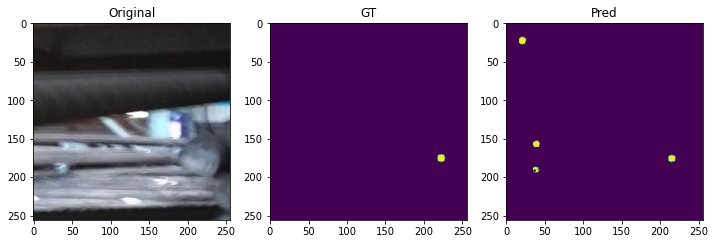

MAPE: 3.0


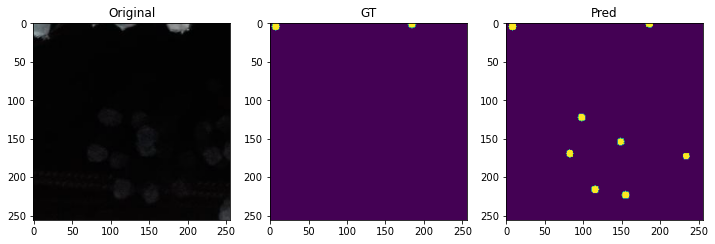

MeanAPE: 0.13308606755165245, MedianAPE: 0.039230769230769236


In [17]:
# Collect MAPE
iters_num = 0
MAPE = []

for img in tqdm(valid_dataloader):
  for i in range(img[0].shape[0]):
    img_original = img[0][i:i+1]
    pred = (model.predict(img_original) > 0.5)[0, ..., 0]
    gt = img[1][i]
    # by connected components
    num_preds, _ = cv2.connectedComponents(pred.astype(np.uint8))
    num_gt, _ = cv2.connectedComponents(gt.astype(np.uint8))
    num_preds -= 1
    num_gt -= 1
    mape_temp = abs((num_gt - num_preds) / num_gt)
    MAPE.append(mape_temp)

    if mape_temp > 2:
      # plot
      print(f"MAPE: {mape_temp}")
      fig, ax = plt.subplots(1, 3, figsize=(12,10))
      ax[0].imshow(img_original[0])
      ax[0].set_title("Original")
      ax[1].imshow(gt[..., 0])
      ax[1].set_title("GT")
      ax[2].imshow(pred)
      ax[2].set_title("Pred")
      plt.show()

    # update iters_num
    iters_num += 1

print(f"MeanAPE: {np.mean(MAPE)}, MedianAPE: {np.median(MAPE)}")

In [18]:
# Collect Test Statistics
# Prepare data for test
data_test, labels_test = [], []
for img_name in test_labels:
  metadata = test_labels[img_name]
  # get data
  img = cv2.imread("Пакеты_тест/" + metadata["filename"])
  data_test.append(img.astype("float32") / 255)
  # get labels
  labels_test.append(len(metadata["regions"].values()))

data_test = np.array(data_test)
labels_test = np.array(labels_test)

In [19]:
# Collect MAPE
iters_num = 0
MAPE = []

for idx in tqdm(range(data_test.shape[0])):
  img = data_test[idx:idx+1]
  # resize to the closest size
  img = cv2.resize(img[0], (256 * (img.shape[1] // 256), 256 * (img.shape[2] // 256)))
  img = np.expand_dims(img, 0)
  num_preds = 0
  for i in range(img.shape[1] // 256):
    for j in range(img.shape[2] // 256):
      img_crop = img[:, i*256:(i+1)*256, j*256:(j+1)*256]
      pred = (model.predict(img_crop) > 0.5)[0, ..., 0]
      num_preds_crop, _ = cv2.connectedComponents(pred.astype(np.uint8))
      num_preds_crop -= 1
      num_preds += num_preds_crop
  num_gt = labels_test[idx]
  mape_temp = abs((num_gt - num_preds) / num_gt)
  MAPE.append(mape_temp)

  iters_num += 1

print(f"MeanAPE: {np.mean(MAPE)}, MedianAPE: {np.median(MAPE)}")

  0%|          | 0/19 [00:00<?, ?it/s]

MeanAPE: 0.6955020900593363, MedianAPE: 0.7938718662952646
